加载数据完毕
2023-05-12T09:31:00,  SELL : data_name:base price : 3297.8 , cost : -3297.8 , commission : 0.65956
2023-05-12T09:31:00, open symbol is : base , price : 3297.8 
2023-05-12T09:33:00,  SELL : data_name:base price : 3303.63 , cost : -3303.63 , commission : 0.660726
2023-05-12T09:37:00,  SELL : data_name:base price : 3304.38 , cost : -3304.38 , commission : 0.660876
2023-05-12T09:38:00,  SELL : data_name:base price : 3305.65 , cost : -3305.65 , commission : 0.66113
2023-05-12T09:42:00,  SELL : data_name:base price : 3308.3 , cost : -3308.3 , commission : 0.66166
2023-05-12T09:46:00,  SELL : data_name:base price : 3312.67 , cost : -3312.67 , commission : 0.6625340000000001
2023-05-12T09:47:00,  SELL : data_name:base price : 3316.49 , cost : -3316.49 , commission : 0.6632979999999999
2023-05-12T09:51:00,  SELL : data_name:base price : 3319.02 , cost : -3319.02 , commission : 0.6638040000000001
2023-05-12T09:53:00,  SELL : data_name:base price : 3316.46 , cost : -3316.46 , commission : 

Start date,2023-05-12
End date,2023-05-23
Total months,770
,Backtest
Annual return,0.001%
Cumulative returns,0.038%
Annual volatility,0.004%
Sharpe ratio,0.15
Calmar ratio,0.02
Stability,0.02
Max drawdown,-0.027%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,0.03,2023-05-19,2023-05-22,2023-05-23,3
1,0.02,2023-05-15,2023-05-18,2023-05-19,4
2,0.01,2023-05-23,2023-05-23,2023-05-23,1
3,0.01,2023-05-23,2023-05-23,2023-05-23,1
4,0.00,2023-05-19,2023-05-19,2023-05-19,1


Stress Events,mean,min,max
New Normal,0.00%,-0.00%,0.01%


Top 10 long positions of all time,max


Top 10 short positions of all time,max
base,-3.22%


Top 10 positions of all time,max
base,3.22%


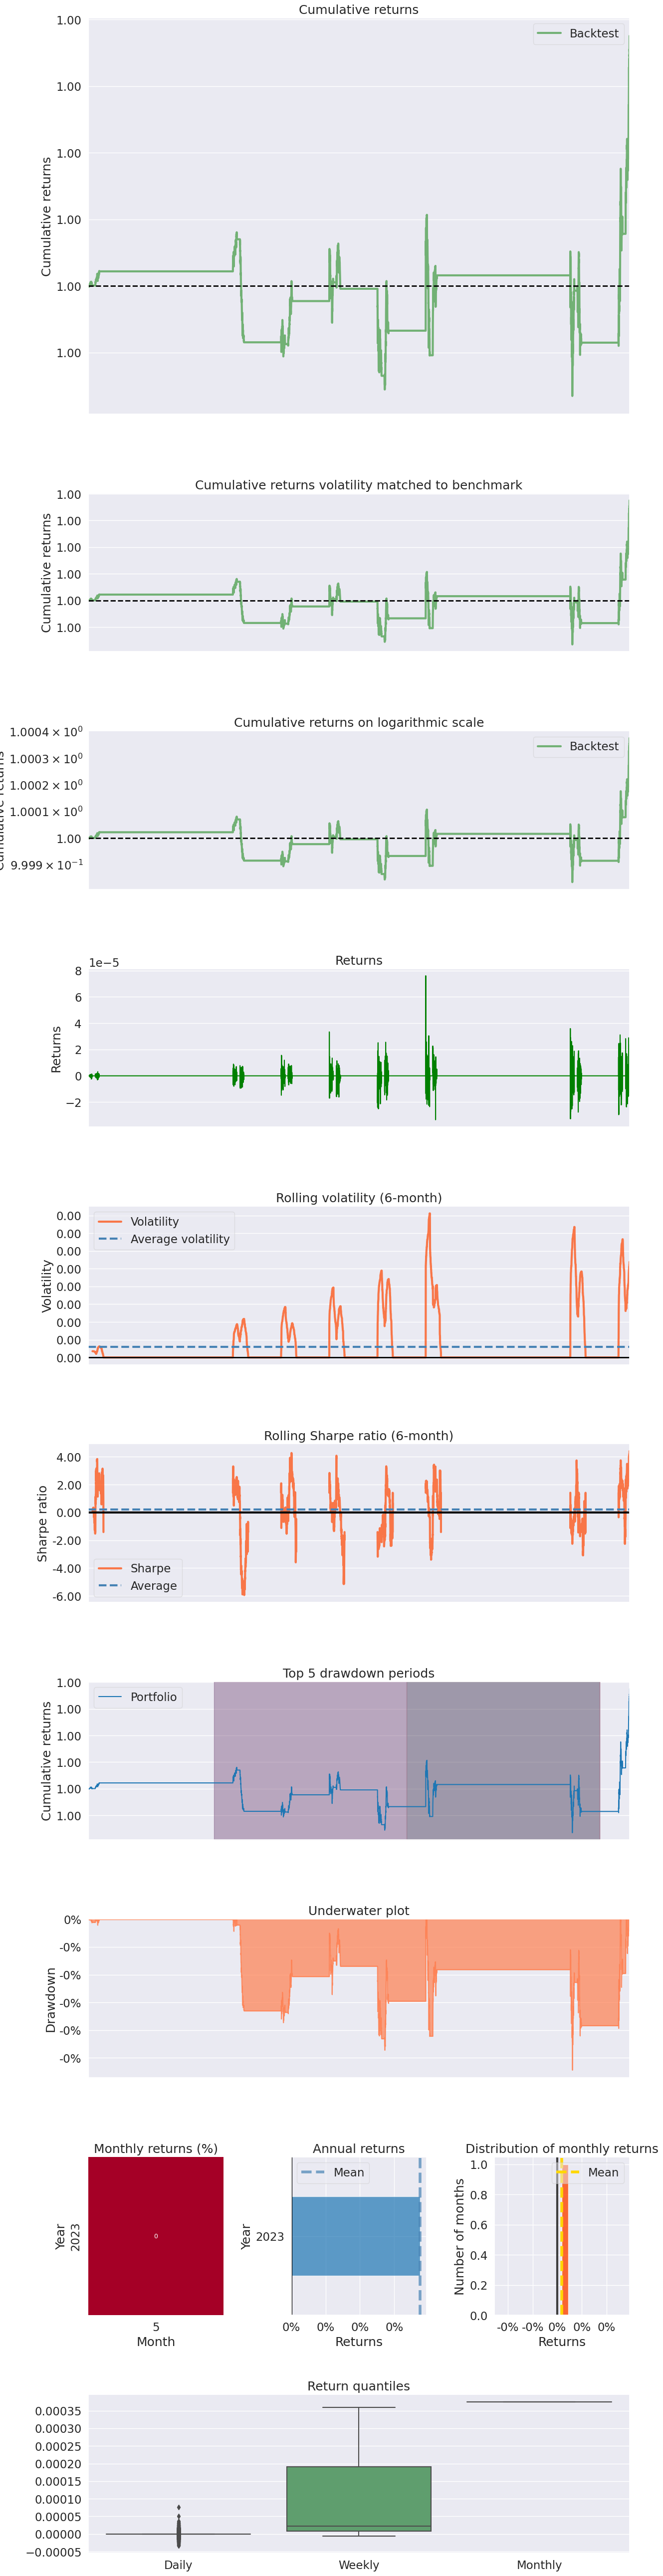

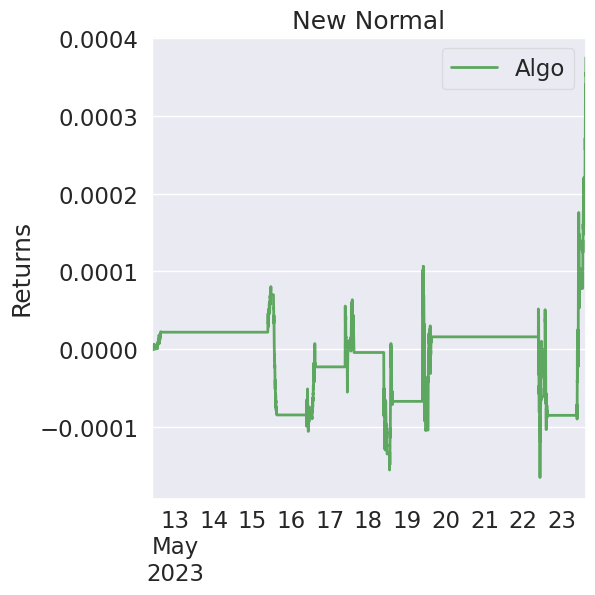

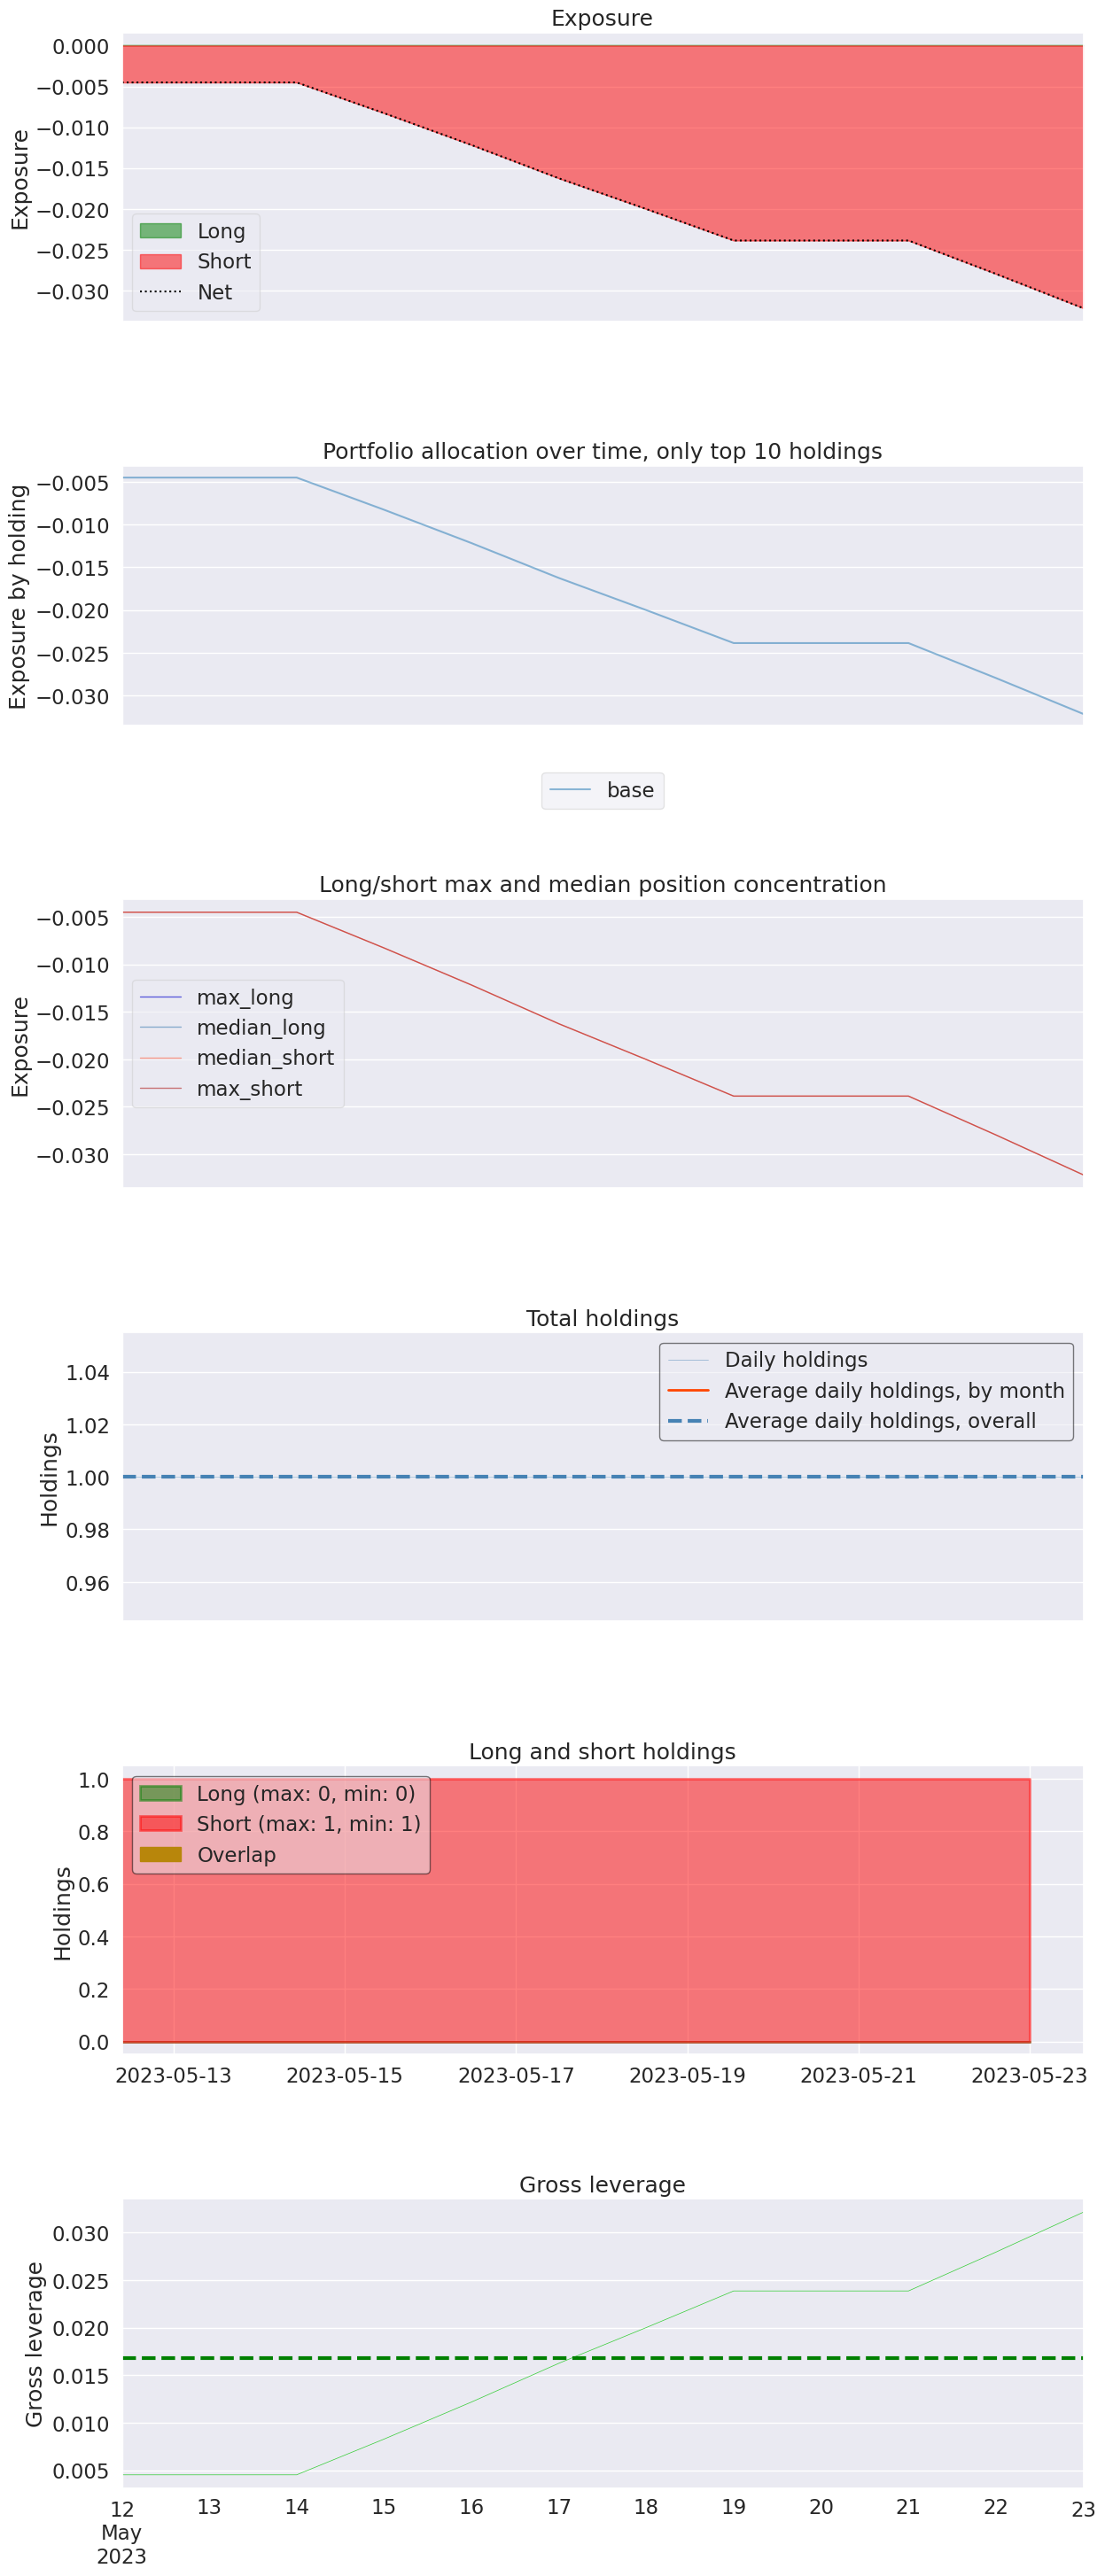

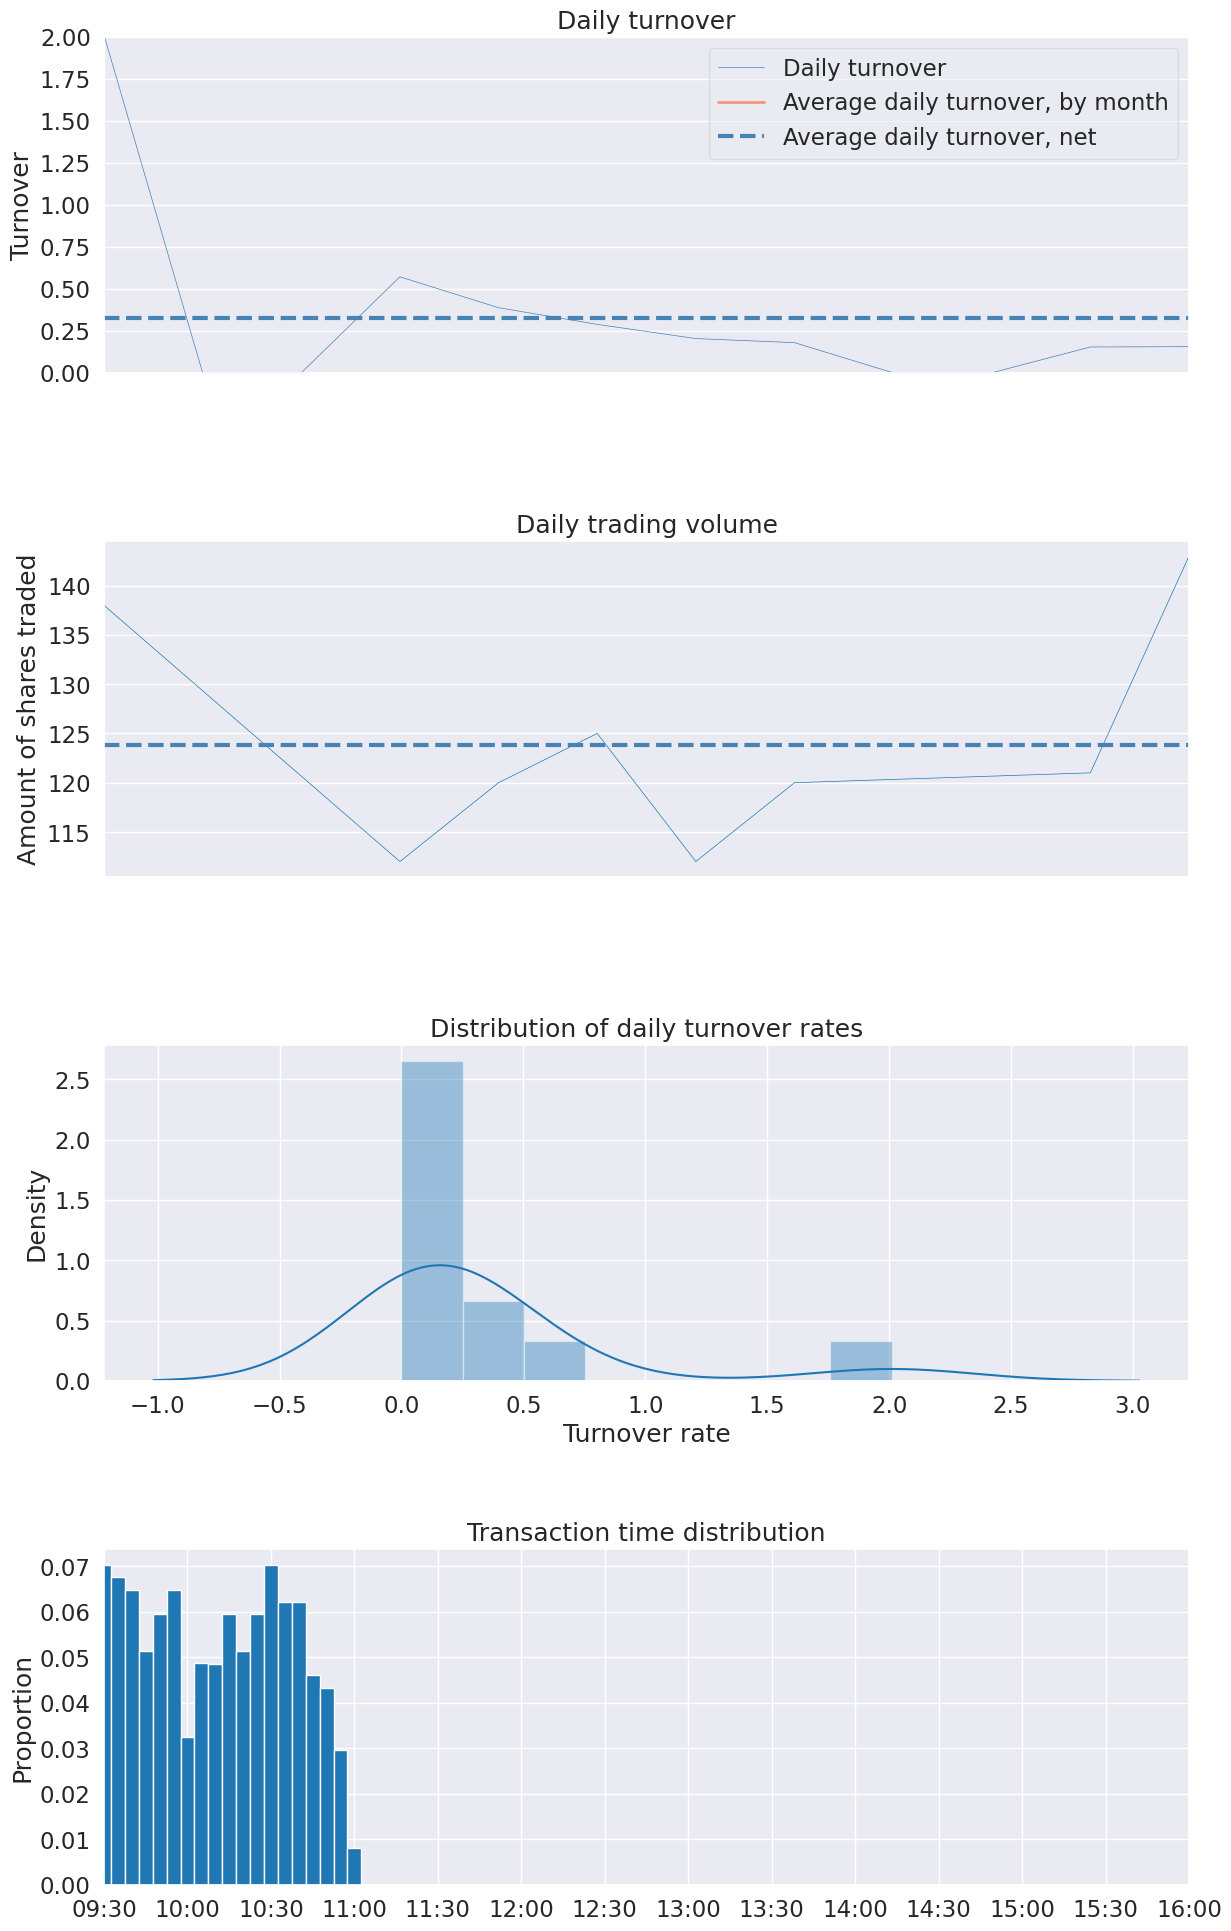

In [1]:
import backtrader as bt
import datetime
import pandas as pd
import numpy as np
import os, sys
import copy
import talib
import math
import warnings

from mysql import MySQLData

warnings.filterwarnings("ignore")
import pyfolio as pf


# 我们使用的时候，直接用我们新的类读取数据就可以了。
class test_two_ma_strategy(bt.Strategy):
    params = (('period', 30),
              ('hold_percent', 0.02)
              )

    def log(self, txt, dt=None):
        ''' Logging function fot this strategy'''
        dt = dt or self.datas[0].datetime.datetime(0)
        print('{}, {}'.format(dt.isoformat(), txt))

    def __init__(self):
        # Keep a reference to the "close" line in the data[0] dataseries
        self.bar_num = 0
        # 保存现有持仓的股票
        self.position_dict = {}
        # 当前有交易的股票
        self.stock_dict = {}

    def prenext(self):

        self.next()

    def next(self):
        current_date = self.datas[0].datetime.datetime(0)
        long_list = []
        short_list = []
        base = self.dnames['base']
        base_change_pct = base.change_pct[0]  # 通过名称调用数据:self.dnames['cg']
        for data in self.datas:
            change_pct = data.change_pct[0]

            condition1 = change_pct - base_change_pct
            if condition1!=0:
                self.log('change_pct, %.3f <> %.3f' % (change_pct, base_change_pct))

            condition2 = data.change_pct[-1] < - base.change_pct[-1]
            condition3 = abs(change_pct) > 0.01 or abs(base_change_pct) > 0.01
            # 增加判断换手率小于3%的条件
            if condition1 > 0.01 and condition2 and condition3:
                self.order = self.buy(data=data)
            continue
        for data in self.datas:
            condition = data.close[0] < data.close[-1]
            if condition > 0.1 or condition < -0.1:
                self.order = self.sell(data=data)
            continue

    def notify_order(self, order):

        if order.status in [order.Submitted, order.Accepted]:
            return

        if order.status == order.Rejected:
            self.log(f"Rejected : order_ref:{order.ref}  data_name:{order.p.data._name}")

        if order.status == order.Margin:
            self.log(f"Margin : order_ref:{order.ref}  data_name:{order.p.data._name}")

        if order.status == order.Cancelled:
            self.log(f"Concelled : order_ref:{order.ref}  data_name:{order.p.data._name}")

        if order.status == order.Partial:
            self.log(f"Partial : order_ref:{order.ref}  data_name:{order.p.data._name}")

        if order.status == order.Completed:
            if order.isbuy():
                self.log(
                    f" BUY : data_name:{order.p.data._name} price : {order.executed.price} , cost : {order.executed.value} , commission : {order.executed.comm}")

            else:  # Sell
                self.log(
                    f" SELL : data_name:{order.p.data._name} price : {order.executed.price} , cost : {order.executed.value} , commission : {order.executed.comm}")

    def notify_trade(self, trade):
        # 一个trade结束的时候输出信息
        if trade.isclosed:
            self.log('closed symbol is : {} , total_profit : {} , net_profit : {}'.format(
                trade.getdataname(), trade.pnl, trade.pnlcomm))
            # self.trade_list.append([self.datas[0].datetime.date(0),trade.getdataname(),trade.pnl,trade.pnlcomm])

        if trade.isopen:
            self.log('open symbol is : {} , price : {} '.format(
                trade.getdataname(), trade.price))

    def stop(self):

        pass

    # 初始化cerebro,获得一个实例


cerebro = bt.Cerebro()
# cerebro.broker = bt.brokers.BackBroker(shortcash=True)  # 0.5%
data_root = "/home/yun/data/stock/day/"

params = dict(

    fromdate=datetime.datetime(2005, 1, 4),
    todate=datetime.datetime(2020, 7, 31),
    timeframe=bt.TimeFrame.Days,
    dtformat=("%Y-%m-%d"),
    compression=1,
    datetime=0,
    open=1,
    high=2,
    low=3,
    close=4,
    volume=5,
    openinterest=-1)

# 加载指数数据

# 添加数据到cerebro
table = "kline_ashare"
base = MySQLData(
    table,
    symbol="sh000001",
    fromdate=datetime.datetime(2023, 1, 1),
    todate=datetime.datetime(2023, 6, 12),
    interval="1m",
)
cerebro.adddata(base, name="base")

symbols = ["sz980030", "300999"]
symbols = []
# 读取数据
for symbol in symbols:
    data1 = MySQLData(
        table,
        symbol=symbol,
        fromdate=datetime.datetime(2023, 1, 1),
        todate=datetime.datetime(2023, 6, 12),
        interval="1m",
    )
    # 添加数据到cerebro
    cerebro.adddata(data1, name=symbol)

print("加载数据完毕")
# 添加手续费，按照万分之二收取
cerebro.broker.setcommission(commission=0.0002, stocklike=True)
# 设置初始资金为100万
cerebro.broker.setcash(1_0000_0000)
# 添加策略
cerebro.addstrategy(test_two_ma_strategy)

cerebro.addanalyzer(bt.analyzers.PyFolio, timeframe=bt.TimeFrame.Minutes, compression=None)
# 运行回测
results = cerebro.run()
# 获取回测结束后的总资金
portvalue = cerebro.broker.getvalue()
pnl = portvalue - cerebro.broker.startingcash
# 打印结果
print(f'总资金:{round(portvalue, 2)}')
print(f'净收益:{round(pnl, 2)}')

pyfoliozer = results[0].analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()
pf.create_full_tear_sheet(
    returns,
    positions=positions,
    transactions=transactions,
    # live_start_date='2023-05-12',
)
